# Gradient Methods


## Top-down start

* We will start with a top-down view, with a simple harmonic oscillator problem in one dimension as case.

* Thereafter we continue with implementing the simplest possible steepest descent approach to our two-electron problem with an electrostatic (Coulomb) interaction. Our code includes also importance sampling. The simple Python code here illustrates the basic elements which need to be included in our own code.

* Then we move on to the mathematical description of various gradient methods.

## Motivation
Our aim with this part of the project is to be able to
* find an optimal value for the variational parameters using only some few Monte Carlo cycles

* use these optimal values for the variational parameters to perform a large-scale Monte Carlo calculation

To achieve this will look at methods like *Steepest descent* and the *conjugate gradient method*. Both these methods allow us to find
the minima of a multivariable  function like our energy (function of several variational parameters). 
Alternatively, you can always use Newton's method. In particular, since we will normally have one variational parameter,
Newton's method can be easily used in finding the minimum of the local energy.




## Simple example and demonstration

Let us illustrate what is needed in our calculations using a simple example, the harmonic oscillator in one dimension.
For the harmonic oscillator in one-dimension we have a  trial wave function and probability

$$
\psi_T(x;\alpha) = \exp{-(\frac{1}{2}\alpha^2x^2)},
$$

which results in a local energy

$$
\frac{1}{2}\left(\alpha^2+x^2(1-\alpha^4)\right).
$$

We can compare our numerically calculated energies with the exact energy as function of $\alpha$

$$
\overline{E}[\alpha] = \frac{1}{4}\left(\alpha^2+\frac{1}{\alpha^2}\right).
$$

## Simple example and demonstration
The derivative of the energy with respect to $\alpha$ gives

$$
\frac{d\langle  E_L[\alpha]\rangle}{d\alpha} = \frac{1}{2}\alpha-\frac{1}{2\alpha^3}
$$

and a second derivative which is always positive (meaning that we find a minimum)

$$
\frac{d^2\langle  E_L[\alpha]\rangle}{d\alpha^2} = \frac{1}{2}+\frac{3}{2\alpha^4}
$$

The condition

$$
\frac{d\langle  E_L[\alpha]\rangle}{d\alpha} = 0,
$$

gives the optimal $\alpha=1$, as expected.






<!-- --- begin exercise --- -->

## Exercise 1: Find the local energy for the harmonic oscillator


**a)**
Derive the local energy for the harmonic oscillator in one dimension and find its expectation value.

**b)**
Show also that the optimal value of optimal $\alpha=1$

**c)**
Repeat the above steps in two dimensions for $N$ bosons or electrons. What is the optimal value of $\alpha$?



<!-- --- end exercise --- -->


## Variance in the simple model
We can also minimize the variance. In our simple model the variance is

$$
\sigma^2[\alpha]=\frac{1}{4}\left(1+(1-\alpha^4)^2\frac{3}{4\alpha^4}\right)-\overline{E}^2.
$$

which yields a second derivative which is always positive.





## Computing the derivatives

In general we end up computing the expectation value of the energy in terms 
of some parameters $\alpha_0,\alpha_1,\dots,\alpha_n$
and we search for a minimum in this multi-variable parameter space.  
This leads to an energy minimization problem *where we need the derivative of the energy as a function of the variational parameters*.

In the above example this was easy and we were able to find the expression for the derivative by simple derivations. 
However, in our actual calculations the energy is represented by a multi-dimensional integral with several variational parameters.
How can we can then obtain the derivatives of the energy with respect to the variational parameters without having 
to resort to expensive numerical derivations?





## Expressions for finding the derivatives of the local energy

To find the derivatives of the local energy expectation value as function of the variational parameters, we can use the chain rule and the hermiticity of the Hamiltonian.  

Let us define

$$
\bar{E}_{\alpha}=\frac{d\langle  E_L[\alpha]\rangle}{d\alpha}.
$$

as the derivative of the energy with respect to the variational parameter $\alpha$ (we limit ourselves to one parameter only).
In the above example this was easy and we obtain a simple expression for the derivative.
We define also the derivative of the trial function (skipping the subindex $T$) as

$$
\bar{\psi}_{\alpha}=\frac{d\psi[\alpha]\rangle}{d\alpha}.
$$

## Derivatives of the local energy
The elements of the gradient of the local energy are then (using the chain rule and the hermiticity of the Hamiltonian)

$$
\bar{E}_{\alpha} = 2\left( \langle \frac{\bar{\psi}_{\alpha}}{\psi[\alpha]}E_L[\alpha]\rangle -\langle \frac{\bar{\psi}_{\alpha}}{\psi[\alpha]}\rangle\langle E_L[\alpha] \rangle\right).
$$

From a computational point of view it means that you need to compute the expectation values of

$$
\langle \frac{\bar{\psi}_{\alpha}}{\psi[\alpha]}E_L[\alpha]\rangle,
$$

and

$$
\langle \frac{\bar{\psi}_{\alpha}}{\psi[\alpha]}\rangle\langle E_L[\alpha]\rangle
$$

<!-- --- begin exercise --- -->

## Exercise 2: General expression for the derivative of the energy


**a)**
Show that

$$
\bar{E}_{\alpha} = 2\left( \langle \frac{\bar{\psi}_{\alpha}}{\psi[\alpha]}E_L[\alpha]\rangle -\langle \frac{\bar{\psi}_{\alpha}}{\psi[\alpha]}\rangle\langle E_L[\alpha] \rangle\right).
$$

**b)**
Find the corresponding expression for the variance.





<!-- --- end exercise --- -->


## Python program for 2-electrons in 2 dimensions

In [1]:
%matplotlib inline

# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added energy minimization with gradient descent using fixed step size
# To do: replace with optimization codes from scipy and/or use stochastic gradient descent
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys



# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha,beta):
    
    WfDer  = np.zeros((2), np.double)
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    WfDer[0] = -0.5*(r1+r2)
    WfDer[1] = -r12*r12*deno2
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce
    

# Computing the derivative of the energy and the energy 
def EnergyMinimization(alpha, beta):

    NumberMCcycles= 10000
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator 
    seed()
    energy = 0.0
    DeltaE = 0.0
    EnergyDer = np.zeros((2), np.double)
    DeltaPsi = np.zeros((2), np.double)
    DerivativePsiE = np.zeros((2), np.double)
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        DerPsi = DerivativeWFansatz(PositionOld,alpha,beta)
        DeltaPsi += DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return energy, EnergyDer


#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# guess for variational parameters
alpha = 0.9
beta = 0.2
# Set up iteration using gradient descent method
Energy = 0
EDerivative = np.zeros((2), np.double)
eta = 0.01
Niterations = 50
# 
for iter in range(Niterations):
    Energy, EDerivative = EnergyMinimization(alpha,beta)
    alphagradient = EDerivative[0]
    betagradient = EDerivative[1]
    alpha -= eta*alphagradient
    beta -= eta*betagradient 

print(alpha, beta)
print(Energy, EDerivative[0], EDerivative[1])

1.0089527557932383 0.31821135079770246
2.9980655290299114 -0.0471158400682361 -0.0792988970716646


## Using Broyden's algorithm in scipy
The following function uses the above described BFGS algorithm. Here we have defined a function which calculates the energy and a function which computes the first derivative.

In [2]:
# 2-electron VMC code for 2dim quantum dot with importance sampling
# Using gaussian rng for new positions and Metropolis- Hastings 
# Added energy minimization using the BFGS algorithm, see p. 136 of https://www.springer.com/it/book/9780387303031
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import minimize
import sys


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

# Derivate of wave function ansatz as function of variational parameters
def DerivativeWFansatz(r,alpha,beta):
    
    WfDer  = np.zeros((2), np.double)
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    WfDer[0] = -0.5*(r1+r2)
    WfDer[1] = -r12*r12*deno2
    return  WfDer

# Setting up the quantum force for the two-electron quantum dot, recall that it is a vector
def QuantumForce(r,alpha,beta):

    qforce = np.zeros((NumberParticles,Dimension), np.double)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    qforce[0,:] = -2*r[0,:]*alpha*(r[0,:]-r[1,:])*deno*deno/r12
    qforce[1,:] = -2*r[1,:]*alpha*(r[1,:]-r[0,:])*deno*deno/r12
    return qforce
    

# Computing the derivative of the energy and the energy 
def EnergyDerivative(x0):

    
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    NumberMCcycles= 10000
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    EnergyDer = 0.0
    DeltaPsi = 0.0
    DerivativePsiE = 0.0 
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        DerPsi = DerivativeWFansatz(PositionOld,alpha,beta)
        DeltaPsi += DerPsi
        energy += DeltaE
        DerivativePsiE += DerPsi*DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    DerivativePsiE /= NumberMCcycles
    DeltaPsi /= NumberMCcycles
    EnergyDer  = 2*(DerivativePsiE-DeltaPsi*energy)
    return EnergyDer


# Computing the expectation value of the local energy 
def Energy(x0):
    # Parameters in the Fokker-Planck simulation of the quantum force
    D = 0.5
    TimeStep = 0.05
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((NumberParticles,Dimension), np.double)
    QuantumForceNew = np.zeros((NumberParticles,Dimension), np.double)

    energy = 0.0
    DeltaE = 0.0
    alpha = x0[0]
    beta = x0[1]
    NumberMCcycles= 10000
    #Initial position
    for i in range(NumberParticles):
        for j in range(Dimension):
            PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(TimeStep)
    wfold = WaveFunction(PositionOld,alpha,beta)
    QuantumForceOld = QuantumForce(PositionOld,alpha, beta)

    #Loop over MC MCcycles
    for MCcycle in range(NumberMCcycles):
        #Trial position moving one particle at the time
        for i in range(NumberParticles):
            for j in range(Dimension):
                PositionNew[i,j] = PositionOld[i,j]+normalvariate(0.0,1.0)*sqrt(TimeStep)+\
                                       QuantumForceOld[i,j]*TimeStep*D
            wfnew = WaveFunction(PositionNew,alpha,beta)
            QuantumForceNew = QuantumForce(PositionNew,alpha, beta)
            GreensFunction = 0.0
            for j in range(Dimension):
                GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*\
	                              (D*TimeStep*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])-\
                                      PositionNew[i,j]+PositionOld[i,j])
      
            GreensFunction = exp(GreensFunction)
            ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
            #Metropolis-Hastings test to see whether we accept the move
            if random() <= ProbabilityRatio:
                for j in range(Dimension):
                    PositionOld[i,j] = PositionNew[i,j]
                    QuantumForceOld[i,j] = QuantumForceNew[i,j]
                wfold = wfnew
        DeltaE = LocalEnergy(PositionOld,alpha,beta)
        energy += DeltaE
            
    # We calculate mean values
    energy /= NumberMCcycles
    return energy




#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
# seed for rng generator 
seed()
# guess for variational parameters
x0 = np.array([0.9,0.2])
# Using Broydens method
res = minimize(Energy, x0, method='BFGS', jac=EnergyDerivative, options={'gtol': 1e-4,'disp': True})
print(res.x)

         Current function value: 2.998004
         Iterations: 5
         Function evaluations: 24
         Gradient evaluations: 12
[0.98510787 0.41129701]


Note that the **minimize** function returns the finale values for the variable $\alpha=x0[0]$ and $\beta=x0[1]$ in the array $x$. 



## Brief reminder on Newton-Raphson's method

Let us quickly remind ourselves how we derive the above method.

Perhaps the most celebrated of all one-dimensional root-finding
routines is Newton's method, also called the Newton-Raphson
method. This method  requires the evaluation of both the
function $f$ and its derivative $f'$ at arbitrary points. 
If you can only calculate the derivative
numerically and/or your function is not of the smooth type, we
normally discourage the use of this method.


## The equations

The Newton-Raphson formula consists geometrically of extending the
tangent line at a current point until it crosses zero, then setting
the next guess to the abscissa of that zero-crossing.  The mathematics
behind this method is rather simple. Employing a Taylor expansion for
$x$ sufficiently close to the solution $s$, we have

<!-- Equation labels as ordinary links -->
<div id="eq:taylornr"></div>

$$
f(s)=0=f(x)+(s-x)f'(x)+\frac{(s-x)^2}{2}f''(x) +\dots.
    \label{eq:taylornr} \tag{1}
$$

For small enough values of the function and for well-behaved
functions, the terms beyond linear are unimportant, hence we obtain

$$
f(x)+(s-x)f'(x)\approx 0,
$$

yielding

$$
s\approx x-\frac{f(x)}{f'(x)}.
$$

Having in mind an iterative procedure, it is natural to start iterating with

$$
x_{n+1}=x_n-\frac{f(x_n)}{f'(x_n)}.
$$

## Simple geometric interpretation

The above is Newton-Raphson's method. It has a simple geometric
interpretation, namely $x_{n+1}$ is the point where the tangent from
$(x_n,f(x_n))$ crosses the $x$-axis.  Close to the solution,
Newton-Raphson converges fast to the desired result. However, if we
are far from a root, where the higher-order terms in the series are
important, the Newton-Raphson formula can give grossly inaccurate
results. For instance, the initial guess for the root might be so far
from the true root as to let the search interval include a local
maximum or minimum of the function.  If an iteration places a trial
guess near such a local extremum, so that the first derivative nearly
vanishes, then Newton-Raphson may fail totally



## Extending to more than one variable

Newton's method can be generalized to systems of several non-linear equations
and variables. Consider the case with two equations

$$
\begin{array}{cc} f_1(x_1,x_2) &=0\\
                     f_2(x_1,x_2) &=0,\end{array}
$$

which we Taylor expand to obtain

$$
\begin{array}{cc} 0=f_1(x_1+h_1,x_2+h_2)=&f_1(x_1,x_2)+h_1
                     \partial f_1/\partial x_1+h_2
                     \partial f_1/\partial x_2+\dots\\
                     0=f_2(x_1+h_1,x_2+h_2)=&f_2(x_1,x_2)+h_1
                     \partial f_2/\partial x_1+h_2
                     \partial f_2/\partial x_2+\dots
                       \end{array}.
$$

Defining the Jacobian matrix $\hat{J}$ we have

$$
\hat{J}=\left( \begin{array}{cc}
                         \partial f_1/\partial x_1  & \partial f_1/\partial x_2 \\
                          \partial f_2/\partial x_1     &\partial f_2/\partial x_2
             \end{array} \right),
$$

we can rephrase Newton's method as

$$
\left(\begin{array}{c} x_1^{n+1} \\ x_2^{n+1} \end{array} \right)=
\left(\begin{array}{c} x_1^{n} \\ x_2^{n} \end{array} \right)+
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right),
$$

where we have defined

$$
\left(\begin{array}{c} h_1^{n} \\ h_2^{n} \end{array} \right)=
   -{\bf \hat{J}}^{-1}
   \left(\begin{array}{c} f_1(x_1^{n},x_2^{n}) \\ f_2(x_1^{n},x_2^{n}) \end{array} \right).
$$

We need thus to compute the inverse of the Jacobian matrix and it
is to understand that difficulties  may
arise in case $\hat{J}$ is nearly singular.

It is rather straightforward to extend the above scheme to systems of
more than two non-linear equations. In our case, the Jacobian matrix is given by the Hessian that represents the second derivative of cost function. 




## Steepest descent

The basic idea of gradient descent is
that a function $F(\mathbf{x})$, 
$\mathbf{x} \equiv (x_1,\cdots,x_n)$, decreases fastest if one goes from $\bf {x}$ in the
direction of the negative gradient $-\nabla F(\mathbf{x})$.

It can be shown that if

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k),
$$

with $\gamma_k > 0$.

For $\gamma_k$ small enough, then $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$. This means that for a sufficiently small $\gamma_k$
we are always moving towards smaller function values, i.e a minimum.


## More on Steepest descent

The previous observation is the basis of the method of steepest
descent, which is also referred to as just gradient descent (GD). One
starts with an initial guess $\mathbf{x}_0$ for a minimum of $F$ and
computes new approximations according to

$$
\mathbf{x}_{k+1} = \mathbf{x}_k - \gamma_k \nabla F(\mathbf{x}_k), \ \ k \geq 0.
$$

The parameter $\gamma_k$ is often referred to as the step length or
the learning rate within the context of Machine Learning.


## The ideal

Ideally the sequence $\{\mathbf{x}_k \}_{k=0}$ converges to a global
minimum of the function $F$. In general we do not know if we are in a
global or local minimum. In the special case when $F$ is a convex
function, all local minima are also global minima, so in this case
gradient descent can converge to the global solution. The advantage of
this scheme is that it is conceptually simple and straightforward to
implement. However the method in this form has some severe
limitations:

In machine learing we are often faced with non-convex high dimensional
cost functions with many local minima. Since GD is deterministic we
will get stuck in a local minimum, if the method converges, unless we
have a very good intial guess. This also implies that the scheme is
sensitive to the chosen initial condition.

Note that the gradient is a function of $\mathbf{x} =
(x_1,\cdots,x_n)$ which makes it expensive to compute numerically.



## The sensitiveness of the gradient descent

The gradient descent method 
is sensitive to the choice of learning rate $\gamma_k$. This is due
to the fact that we are only guaranteed that $F(\mathbf{x}_{k+1}) \leq
F(\mathbf{x}_k)$ for sufficiently small $\gamma_k$. The problem is to
determine an optimal learning rate. If the learning rate is chosen too
small the method will take a long time to converge and if it is too
large we can experience erratic behavior.

Many of these shortcomings can be alleviated by introducing
randomness. One such method is that of Stochastic Gradient Descent
(SGD), see below.



## Convex functions

Ideally we want our cost/loss function to be convex(concave).

First we give the definition of a convex set: A set $C$ in
$\mathbb{R}^n$ is said to be convex if, for all $x$ and $y$ in $C$ and
all $t \in (0,1)$ , the point $(1 − t)x + ty$ also belongs to
C. Geometrically this means that every point on the line segment
connecting $x$ and $y$ is in $C$ as discussed below.

The convex subsets of $\mathbb{R}$ are the intervals of
$\mathbb{R}$. Examples of convex sets of $\mathbb{R}^2$ are the
regular polygons (triangles, rectangles, pentagons, etc...).


## Convex function

**Convex function**: Let $X \subset \mathbb{R}^n$ be a convex set. Assume that the function $f: X \rightarrow \mathbb{R}$ is continuous, then $f$ is said to be convex if $$f(tx_1 + (1-t)x_2) \leq tf(x_1) + (1-t)f(x_2) $$ for all $x_1, x_2 \in X$ and for all $t \in [0,1]$. If $\leq$ is replaced with a strict inequaltiy in the definition, we demand $x_1 \neq x_2$ and $t\in(0,1)$ then $f$ is said to be strictly convex. For a single variable function, convexity means that if you draw a straight line connecting $f(x_1)$ and $f(x_2)$, the value of the function on the interval $[x_1,x_2]$ is always below the line as illustrated below.


## Conditions on convex functions

In the following we state first and second-order conditions which
ensures convexity of a function $f$. We write $D_f$ to denote the
domain of $f$, i.e the subset of $R^n$ where $f$ is defined. For more
details and proofs we refer to: [S. Boyd and L. Vandenberghe. Convex Optimization. Cambridge University Press](http://stanford.edu/boyd/cvxbook/, 2004).

**First order condition.**

Suppose $f$ is differentiable (i.e $\nabla f(x)$ is well defined for
all $x$ in the domain of $f$). Then $f$ is convex if and only if $D_f$
is a convex set and $$f(y) \geq f(x) + \nabla f(x)^T (y-x) $$ holds
for all $x,y \in D_f$. This condition means that for a convex function
the first order Taylor expansion (right hand side above) at any point
a global under estimator of the function. To convince yourself you can
make a drawing of $f(x) = x^2+1$ and draw the tangent line to $f(x)$ and
note that it is always below the graph.



**Second order condition.**

Assume that $f$ is twice
differentiable, i.e the Hessian matrix exists at each point in
$D_f$. Then $f$ is convex if and only if $D_f$ is a convex set and its
Hessian is positive semi-definite for all $x\in D_f$. For a
single-variable function this reduces to $f''(x) \geq 0$. Geometrically this means that $f$ has nonnegative curvature
everywhere.



This condition is particularly useful since it gives us an procedure for determining if the function under consideration is convex, apart from using the definition.


## More on convex functions

The next result is of great importance to us and the reason why we are
going on about convex functions. In machine learning we frequently
have to minimize a loss/cost function in order to find the best
parameters for the model we are considering. 

Ideally we want the
global minimum (for high-dimensional models it is hard to know
if we have local or global minimum). However, if the cost/loss function
is convex the following result provides invaluable information:

**Any minimum is global for convex functions.**

Consider the problem of finding $x \in \mathbb{R}^n$ such that $f(x)$
is minimal, where $f$ is convex and differentiable. Then, any point
$x^*$ that satisfies $\nabla f(x^*) = 0$ is a global minimum.



This result means that if we know that the cost/loss function is convex and we are able to find a minimum, we are guaranteed that it is a global minimum.


## Some simple problems

1. Show that $f(x)=x^2$ is convex for $x \in \mathbb{R}$ using the definition of convexity. Hint: If you re-write the definition, $f$ is convex if the following holds for all $x,y \in D_f$ and any $\lambda \in [0,1]$ $\lambda f(x)+(1-\lambda)f(y)-f(\lambda x + (1-\lambda) y ) \geq 0$.

2. Using the second order condition show that the following functions are convex on the specified domain.

 * $f(x) = e^x$ is convex for $x \in \mathbb{R}$.

 * $g(x) = -\ln(x)$ is convex for $x \in (0,\infty)$.


3. Let $f(x) = x^2$ and $g(x) = e^x$. Show that $f(g(x))$ and $g(f(x))$ is convex for $x \in \mathbb{R}$. Also show that if $f(x)$ is any convex function than $h(x) = e^{f(x)}$ is convex.

4. A norm is any function that satisfy the following properties

 * $f(\alpha x) = |\alpha| f(x)$ for all $\alpha \in \mathbb{R}$.

 * $f(x+y) \leq f(x) + f(y)$

 * $f(x) \leq 0$ for all $x \in \mathbb{R}^n$ with equality if and only if $x = 0$


Using the definition of convexity, try to show that a function satisfying the properties above is convex (the third condition is not needed to show this).



## Standard steepest descent


Before we proceed, we would like to discuss the approach called the
**standard Steepest descent**, which again leads to us having to be able
to compute a matrix. It belongs to the class of Conjugate Gradient methods (CG).

[The success of the CG method](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf)
for finding solutions of non-linear problems is based on the theory
of conjugate gradients for linear systems of equations. It belongs to
the class of iterative methods for solving problems from linear
algebra of the type

$$
\hat{A}\hat{x} = \hat{b}.
$$

In the iterative process we end up with a problem like

$$
\hat{r}= \hat{b}-\hat{A}\hat{x},
$$

where $\hat{r}$ is the so-called residual or error in the iterative process.

When we have found the exact solution, $\hat{r}=0$.


## Gradient method

The residual is zero when we reach the minimum of the quadratic equation

$$
P(\hat{x})=\frac{1}{2}\hat{x}^T\hat{A}\hat{x} - \hat{x}^T\hat{b},
$$

with the constraint that the matrix $\hat{A}$ is positive definite and
symmetric.  This defines also the Hessian and we want it to be  positive definite.  



## Steepest descent  method

We denote the initial guess for $\hat{x}$ as $\hat{x}_0$. 
We can assume without loss of generality that

$$
\hat{x}_0=0,
$$

or consider the system

$$
\hat{A}\hat{z} = \hat{b}-\hat{A}\hat{x}_0,
$$

instead.



## Steepest descent  method
One can show that the solution $\hat{x}$ is also the unique minimizer of the quadratic form

$$
f(\hat{x}) = \frac{1}{2}\hat{x}^T\hat{A}\hat{x} - \hat{x}^T \hat{x} , \quad \hat{x}\in\mathbf{R}^n.
$$

This suggests taking the first basis vector $\hat{r}_1$ (see below for definition) 
to be the gradient of $f$ at $\hat{x}=\hat{x}_0$, 
which equals

$$
\hat{A}\hat{x}_0-\hat{b},
$$

and 
$\hat{x}_0=0$ it is equal $-\hat{b}$.




## Final expressions
We can compute the residual iteratively as

$$
\hat{r}_{k+1}=\hat{b}-\hat{A}\hat{x}_{k+1},
$$

which equals

$$
\hat{b}-\hat{A}(\hat{x}_k+\alpha_k\hat{r}_k),
$$

or

$$
(\hat{b}-\hat{A}\hat{x}_k)-\alpha_k\hat{A}\hat{r}_k,
$$

which gives

$$
\alpha_k = \frac{\hat{r}_k^T\hat{r}_k}{\hat{r}_k^T\hat{A}\hat{r}_k}
$$

leading to the iterative scheme

$$
\hat{x}_{k+1}=\hat{x}_k-\alpha_k\hat{r}_{k},
$$

## Code examples for steepest descent


## Simple codes for  steepest descent and conjugate gradient using a $2\times 2$ matrix, in c++, Python code to come

        #include <cmath>
        #include <iostream>
        #include <fstream>
        #include <iomanip>
        #include "vectormatrixclass.h"
        using namespace  std;
        //   Main function begins here
        int main(int  argc, char * argv[]){
          int dim = 2;
          Vector x(dim),xsd(dim), b(dim),x0(dim);
          Matrix A(dim,dim);
        
          // Set our initial guess
          x0(0) = x0(1) = 0;
          // Set the matrix
          A(0,0) =  3;    A(1,0) =  2;   A(0,1) =  2;   A(1,1) =  6;
          b(0) = 2; b(1) = -8;
          cout << "The Matrix A that we are using: " << endl;
          A.Print();
          cout << endl;
          xsd = SteepestDescent(A,b,x0);
          cout << "The approximate solution using Steepest Descent is: " << endl;
          xsd.Print();
          cout << endl;
        }


## The routine for the steepest descent method

        Vector SteepestDescent(Matrix A, Vector b, Vector x0){
          int IterMax, i;
          int dim = x0.Dimension();
          const double tolerance = 1.0e-14;
          Vector x(dim),f(dim),z(dim);
          double c,alpha,d;
          IterMax = 30;
          x = x0;
          r = A*x-b;
          i = 0;
          while (i <= IterMax){
            z = A*r;
            c = dot(r,r);
            alpha = c/dot(r,z);
            x = x - alpha*r;
            r =  A*x-b;
            if(sqrt(dot(r,r)) < tolerance) break;
            i++;
          }
          return x;
        }


## Steepest descent example

<ipython-input-3-2fd7e961608e>:16: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


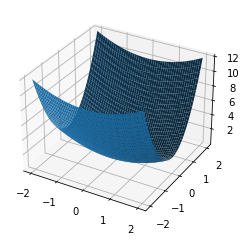

In [3]:
import numpy as np
import numpy.linalg as la

import scipy.optimize as sopt

import matplotlib.pyplot as pt
from mpl_toolkits.mplot3d import axes3d

def f(x):
    return 0.5*x[0]**2 + 2.5*x[1]**2

def df(x):
    return np.array([x[0], 5*x[1]])

fig = pt.figure()
ax = fig.gca(projection="3d")

xmesh, ymesh = np.mgrid[-2:2:50j,-2:2:50j]
fmesh = f(np.array([xmesh, ymesh]))
ax.plot_surface(xmesh, ymesh, fmesh)

And then as countor plot

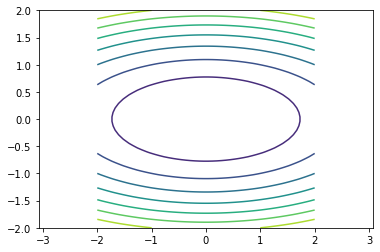

In [4]:
pt.axis("equal")
pt.contour(xmesh, ymesh, fmesh)
guesses = [np.array([2, 2./5])]

Find guesses

In [5]:
x = guesses[-1]
s = -df(x)

Run it!

In [6]:
def f1d(alpha):
    return f(x + alpha*s)

alpha_opt = sopt.golden(f1d)
next_guess = x + alpha_opt * s
guesses.append(next_guess)
print(next_guess)

[ 1.33333333 -0.26666667]


What happened?

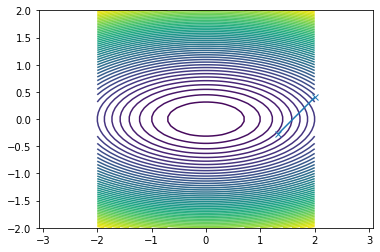

In [7]:
pt.axis("equal")
pt.contour(xmesh, ymesh, fmesh, 50)
it_array = np.array(guesses)
pt.plot(it_array.T[0], it_array.T[1], "x-")

## Conjugate gradient method
In the CG method we define so-called conjugate directions and two vectors 
$\hat{s}$ and $\hat{t}$
are said to be
conjugate if

$$
\hat{s}^T\hat{A}\hat{t}= 0.
$$

The philosophy of the CG method is to perform searches in various conjugate directions
of our vectors $\hat{x}_i$ obeying the above criterion, namely

$$
\hat{x}_i^T\hat{A}\hat{x}_j= 0.
$$

Two vectors are conjugate if they are orthogonal with respect to 
this inner product. Being conjugate is a symmetric relation: if $\hat{s}$ is conjugate to $\hat{t}$, then $\hat{t}$ is conjugate to $\hat{s}$.




## Conjugate gradient method
An example is given by the eigenvectors of the matrix

$$
\hat{v}_i^T\hat{A}\hat{v}_j= \lambda\hat{v}_i^T\hat{v}_j,
$$

which is zero unless $i=j$.





## Conjugate gradient method
Assume now that we have a symmetric positive-definite matrix $\hat{A}$ of size
$n\times n$. At each iteration $i+1$ we obtain the conjugate direction of a vector

$$
\hat{x}_{i+1}=\hat{x}_{i}+\alpha_i\hat{p}_{i}.
$$

We assume that $\hat{p}_{i}$ is a sequence of $n$ mutually conjugate directions. 
Then the $\hat{p}_{i}$  form a basis of $R^n$ and we can expand the solution 
$  \hat{A}\hat{x} = \hat{b}$ in this basis, namely

$$
\hat{x}  = \sum^{n}_{i=1} \alpha_i \hat{p}_i.
$$

## Conjugate gradient method
The coefficients are given by

$$
\mathbf{A}\mathbf{x} = \sum^{n}_{i=1} \alpha_i \mathbf{A} \mathbf{p}_i = \mathbf{b}.
$$

Multiplying with $\hat{p}_k^T$  from the left gives

$$
\hat{p}_k^T \hat{A}\hat{x} = \sum^{n}_{i=1} \alpha_i\hat{p}_k^T \hat{A}\hat{p}_i= \hat{p}_k^T \hat{b},
$$

and we can define the coefficients $\alpha_k$ as

$$
\alpha_k = \frac{\hat{p}_k^T \hat{b}}{\hat{p}_k^T \hat{A} \hat{p}_k}
$$

## Conjugate gradient method and iterations

If we choose the conjugate vectors $\hat{p}_k$ carefully, 
then we may not need all of them to obtain a good approximation to the solution 
$\hat{x}$. 
We want to regard the conjugate gradient method as an iterative method. 
This will us to solve systems where $n$ is so large that the direct 
method would take too much time.

We denote the initial guess for $\hat{x}$ as $\hat{x}_0$. 
We can assume without loss of generality that

$$
\hat{x}_0=0,
$$

or consider the system

$$
\hat{A}\hat{z} = \hat{b}-\hat{A}\hat{x}_0,
$$

instead.





## Conjugate gradient method
One can show that the solution $\hat{x}$ is also the unique minimizer of the quadratic form

$$
f(\hat{x}) = \frac{1}{2}\hat{x}^T\hat{A}\hat{x} - \hat{x}^T \hat{x} , \quad \hat{x}\in\mathbf{R}^n.
$$

This suggests taking the first basis vector $\hat{p}_1$ 
to be the gradient of $f$ at $\hat{x}=\hat{x}_0$, 
which equals

$$
\hat{A}\hat{x}_0-\hat{b},
$$

and 
$\hat{x}_0=0$ it is equal $-\hat{b}$.
The other vectors in the basis will be conjugate to the gradient, 
hence the name conjugate gradient method.





## Conjugate gradient method
Let  $\hat{r}_k$ be the residual at the $k$-th step:

$$
\hat{r}_k=\hat{b}-\hat{A}\hat{x}_k.
$$

Note that $\hat{r}_k$ is the negative gradient of $f$ at 
$\hat{x}=\hat{x}_k$, 
so the gradient descent method would be to move in the direction $\hat{r}_k$. 
Here, we insist that the directions $\hat{p}_k$ are conjugate to each other, 
so we take the direction closest to the gradient $\hat{r}_k$  
under the conjugacy constraint. 
This gives the following expression

$$
\hat{p}_{k+1}=\hat{r}_k-\frac{\hat{p}_k^T \hat{A}\hat{r}_k}{\hat{p}_k^T\hat{A}\hat{p}_k} \hat{p}_k.
$$

## Conjugate gradient method
We can also  compute the residual iteratively as

$$
\hat{r}_{k+1}=\hat{b}-\hat{A}\hat{x}_{k+1},
$$

which equals

$$
\hat{b}-\hat{A}(\hat{x}_k+\alpha_k\hat{p}_k),
$$

or

$$
(\hat{b}-\hat{A}\hat{x}_k)-\alpha_k\hat{A}\hat{p}_k,
$$

which gives

$$
\hat{r}_{k+1}=\hat{r}_k-\hat{A}\hat{p}_{k},
$$

## Simple implementation of the Conjugate gradient algorithm

          Vector ConjugateGradient(Matrix A, Vector b, Vector x0){
          int dim = x0.Dimension();
          const double tolerance = 1.0e-14;
          Vector x(dim),r(dim),v(dim),z(dim);
          double c,t,d;
        
          x = x0;
          r = b - A*x;
          v = r;
          c = dot(r,r);
          int i = 0; IterMax = dim;
          while(i <= IterMax){
            z = A*v;
            t = c/dot(v,z);
            x = x + t*v;
            r = r - t*z;
            d = dot(r,r);
            if(sqrt(d) < tolerance)
              break;
            v = r + (d/c)*v;
            c = d;  i++;
          }
          return x;
        } 


## Broyden–Fletcher–Goldfarb–Shanno algorithm
The optimization problem is to minimize $f(\mathbf {x} )$ where $\mathbf {x}$  is a vector in $R^{n}$, and $f$ is a differentiable scalar function. There are no constraints on the values that  $\mathbf {x}$  can take.

The algorithm begins at an initial estimate for the optimal value $\mathbf {x}_{0}$ and proceeds iteratively to get a better estimate at each stage.

The search direction $p_k$ at stage $k$ is given by the solution of the analogue of the Newton equation

$$
B_{k}\mathbf {p} _{k}=-\nabla f(\mathbf {x}_{k}),
$$

where $B_{k}$ is an approximation to the Hessian matrix, which is
updated iteratively at each stage, and $\nabla f(\mathbf {x} _{k})$
is the gradient of the function
evaluated at $x_k$. 
A line search in the direction $p_k$ is then used to
find the next point $x_{k+1}$ by minimising

$$
f(\mathbf {x}_{k}+\alpha \mathbf {p}_{k}),
$$

over the scalar $\alpha > 0$.





## Stochastic Gradient Descent

Stochastic gradient descent (SGD) and variants thereof address some of
the shortcomings of the Gradient descent method discussed above.

The underlying idea of SGD comes from the observation that a given 
function, which we want to minimize, can almost always be written as a
sum over $n$ data points $\{\mathbf{x}_i\}_{i=1}^n$,

$$
C(\mathbf{\beta}) = \sum_{i=1}^n c_i(\mathbf{x}_i,
\mathbf{\beta}).
$$

## Computation of gradients

This in turn means that the gradient can be
computed as a sum over $i$-gradients

$$
\nabla_\beta C(\mathbf{\beta}) = \sum_i^n \nabla_\beta c_i(\mathbf{x}_i,
\mathbf{\beta}).
$$

Stochasticity/randomness is introduced by only taking the
gradient on a subset of the data called minibatches.  If there are $n$
data points and the size of each minibatch is $M$, there will be $n/M$
minibatches. We denote these minibatches by $B_k$ where
$k=1,\cdots,n/M$.


## SGD example
As an example, suppose we have $10$ data points $(\mathbf{x}_1,\cdots, \mathbf{x}_{10})$ 
and we choose to have $M=5$ minibathces,
then each minibatch contains two data points. In particular we have
$B_1 = (\mathbf{x}_1,\mathbf{x}_2), \cdots, B_5 =
(\mathbf{x}_9,\mathbf{x}_{10})$. Note that if you choose $M=1$ you
have only a single batch with all data points and on the other extreme,
you may choose $M=n$ resulting in a minibatch for each datapoint, i.e
$B_k = \mathbf{x}_k$.

The idea is now to approximate the gradient by replacing the sum over
all data points with a sum over the data points in one the minibatches
picked at random in each gradient descent step

$$
\nabla_{\beta}
C(\mathbf{\beta}) = \sum_{i=1}^n \nabla_\beta c_i(\mathbf{x}_i,
\mathbf{\beta}) \rightarrow \sum_{i \in B_k}^n \nabla_\beta
c_i(\mathbf{x}_i, \mathbf{\beta}).
$$

## The gradient step

Thus a gradient descent step now looks like

$$
\beta_{j+1} = \beta_j - \gamma_j \sum_{i \in B_k}^n \nabla_\beta c_i(\mathbf{x}_i,
\mathbf{\beta})
$$

where $k$ is picked at random with equal
probability from $[1,n/M]$. An iteration over the number of
minibathces (n/M) is commonly referred to as an epoch. Thus it is
typical to choose a number of epochs and for each epoch iterate over
the number of minibatches, as exemplified in the code below.


## Simple example code

In [8]:
import numpy as np 

n = 100 #100 datapoints 
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
n_epochs = 10 #number of epochs

j = 0
for epoch in range(1,n_epochs+1):
    for i in range(m):
        k = np.random.randint(m) #Pick the k-th minibatch at random
        #Compute the gradient using the data in minibatch Bk
        #Compute new suggestion for 
        j += 1

Taking the gradient only on a subset of the data has two important
benefits. First, it introduces randomness which decreases the chance
that our opmization scheme gets stuck in a local minima. Second, if
the size of the minibatches are small relative to the number of
datapoints ($M <  n$), the computation of the gradient is much
cheaper since we sum over the datapoints in the $k-th$ minibatch and not
all $n$ datapoints.


## When do we stop?

A natural question is when do we stop the search for a new minimum?
One possibility is to compute the full gradient after a given number
of epochs and check if the norm of the gradient is smaller than some
threshold and stop if true. However, the condition that the gradient
is zero is valid also for local minima, so this would only tell us
that we are close to a local/global minimum. However, we could also
evaluate the cost function at this point, store the result and
continue the search. If the test kicks in at a later stage we can
compare the values of the cost function and keep the $\beta$ that
gave the lowest value.


## Slightly different approach

Another approach is to let the step length $\gamma_j$ depend on the
number of epochs in such a way that it becomes very small after a
reasonable time such that we do not move at all.

As an example, let $e = 0,1,2,3,\cdots$ denote the current epoch and let $t_0, t_1 > 0$ be two fixed numbers. Furthermore, let $t = e \cdot m + i$ where $m$ is the number of minibatches and $i=0,\cdots,m-1$. Then the function $$\gamma_j(t; t_0, t_1) = \frac{t_0}{t+t_1} $$ goes to zero as the number of epochs gets large. I.e. we start with a step length $\gamma_j (0; t_0, t_1) = t_0/t_1$ which decays in *time* $t$.

In this way we can fix the number of epochs, compute $\beta$ and
evaluate the cost function at the end. Repeating the computation will
give a different result since the scheme is random by design. Then we
pick the final $\beta$ that gives the lowest value of the cost
function.

In [9]:
import numpy as np 

def step_length(t,t0,t1):
    return t0/(t+t1)

n = 100 #100 datapoints 
M = 5   #size of each minibatch
m = int(n/M) #number of minibatches
n_epochs = 500 #number of epochs
t0 = 1.0
t1 = 10

gamma_j = t0/t1
j = 0
for epoch in range(1,n_epochs+1):
    for i in range(m):
        k = np.random.randint(m) #Pick the k-th minibatch at random
        #Compute the gradient using the data in minibatch Bk
        #Compute new suggestion for beta
        t = epoch*m+i
        gamma_j = step_length(t,t0,t1)
        j += 1

print("gamma_j after %d epochs: %g" % (n_epochs,gamma_j))

gamma_j after 500 epochs: 9.97108e-05


## Program for stochastic gradient

In [10]:
# Importing various packages
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor

x = 2*np.random.rand(100,1)
y = 4+3*x+np.random.randn(100,1)

xb = np.c_[np.ones((100,1)), x]
theta_linreg = np.linalg.inv(xb.T.dot(xb)).dot(xb.T).dot(y)
print("Own inversion")
print(theta_linreg)
sgdreg = SGDRegressor(n_iter = 50, penalty=None, eta0=0.1)
sgdreg.fit(x,y.ravel())
print("sgdreg from scikit")
print(sgdreg.intercept_, sgdreg.coef_)


theta = np.random.randn(2,1)

eta = 0.1
Niterations = 1000
m = 100

for iter in range(Niterations):
    gradients = 2.0/m*xb.T.dot(xb.dot(theta)-y)
    theta -= eta*gradients
print("theta frm own gd")
print(theta)

xnew = np.array([[0],[2]])
xbnew = np.c_[np.ones((2,1)), xnew]
ypredict = xbnew.dot(theta)
ypredict2 = xbnew.dot(theta_linreg)


n_epochs = 50
t0, t1 = 5, 50
m = 100
def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = xb[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta)-yi)
        eta = learning_schedule(epoch*m+i)
        theta = theta - eta*gradients
print("theta from own sdg")
print(theta)


plt.plot(xnew, ypredict, "r-")
plt.plot(xnew, ypredict2, "b-")
plt.plot(x, y ,'ro')
plt.axis([0,2.0,0, 15.0])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Random numbers ')
plt.show()

Own inversion
[[3.54906564]
 [3.42834867]]


TypeError: __init__() got an unexpected keyword argument 'n_iter'

## Using gradient descent methods, limitations

* **Gradient descent (GD) finds local minima of our function**. Since the GD algorithm is deterministic, if it converges, it will converge to a local minimum of our energy function. Because in ML we are often dealing with extremely rugged landscapes with many local minima, this can lead to poor performance.

* **GD is sensitive to initial conditions**. One consequence of the local nature of GD is that initial conditions matter. Depending on where one starts, one will end up at a different local minima. Therefore, it is very important to think about how one initializes the training process. This is true for GD as well as more complicated variants of GD.

* **Gradients are computationally expensive to calculate for large datasets**. In many cases in statistics and ML, the energy function is a sum of terms, with one term for each data point. For example, in linear regression, $E \propto \sum_{i=1}^n (y_i - \mathbf{w}^T\cdot\mathbf{x}_i)^2$; for logistic regression, the square error is replaced by the cross entropy. To calculate the gradient we have to sum over *all* $n$ data points. Doing this at every GD step becomes extremely computationally expensive. An ingenious solution to this, is to calculate the gradients using small subsets of the data called "mini batches". This has the added benefit of introducing stochasticity into our algorithm.

* **GD is very sensitive to choices of learning rates**. GD is extremely sensitive to the choice of learning rates. If the learning rate is very small, the training process take an extremely long time. For larger learning rates, GD can diverge and give poor results. Furthermore, depending on what the local landscape looks like, we have to modify the learning rates to ensure convergence. Ideally, we would *adaptively* choose the learning rates to match the landscape.

* **GD treats all directions in parameter space uniformly.** Another major drawback of GD is that unlike Newton's method, the learning rate for GD is the same in all directions in parameter space. For this reason, the maximum learning rate is set by the behavior of the steepest direction and this can significantly slow down training. Ideally, we would like to take large steps in flat directions and small steps in steep directions. Since we are exploring rugged landscapes where curvatures change, this requires us to keep track of not only the gradient but second derivatives. The ideal scenario would be to calculate the Hessian but this proves to be too computationally expensive. 

* GD can take exponential time to escape saddle points, even with random initialization. As we mentioned, GD is extremely sensitive to initial condition since it determines the particular local minimum GD would eventually reach. However, even with a good initialization scheme, through the introduction of randomness, GD can still take exponential time to escape saddle points.

## Codes from numerical recipes
You can however use codes we have adapted from the text [Numerical Recipes in C++](http://www.nr.com/), see chapter 10.7.  
Here we present a program, which you also can find at the webpage of the course we use the functions **dfpmin** and **lnsrch**.  This is a variant of the Broyden et al algorithm discussed in the previous slide.

* The program uses the harmonic oscillator in one dimensions as example.

* The program does not use armadillo to handle vectors and matrices, but employs rather my own vector-matrix class. These auxiliary functions, and the main program *model.cpp* can all be found under the [program link here](https://github.com/CompPhysics/ComputationalPhysics2/tree/gh-pages/doc/pub/cg/programs/c%2B%2B).

Below we show only excerpts from the main program. For the full program, see the above link.





## Finding the minimum of the harmonic oscillator model in one dimension

        //   Main function begins here
        int main()
        {
             int n, iter;
             double gtol, fret;
             double alpha;
             n = 1;
        //   reserve space in memory for vectors containing the variational
        //   parameters
             Vector g(n), p(n);
             cout << "Read in guess for alpha" << endl;
             cin >> alpha;
             gtol = 1.0e-5;
        //   now call dfmin and compute the minimum
             p(0) = alpha;
             dfpmin(p, n, gtol, &iter, &fret, Efunction, dEfunction);
             cout << "Value of energy minimum = " << fret << endl;
             cout << "Number of iterations = " << iter << endl;
             cout << "Value of alpha at minimum = " << p(0) << endl;
              return 0;
        }  // end of main program
        


## Functions to observe
The functions **Efunction** and **dEfunction** compute the expectation value of the energy and its derivative.
They use the the quasi-Newton method of [Broyden, Fletcher, Goldfarb, and Shanno (BFGS)](https://www.springer.com/it/book/9780387303031)
It uses the first derivatives only. The BFGS algorithm has proven good performance even for non-smooth optimizations. 
These functions need to be changed when you want to your own derivatives.

        //  this function defines the expectation value of the local energy
        double Efunction(Vector  &x)
        {
          double value = x(0)*x(0)*0.5+1.0/(8*x(0)*x(0));
          return value;
        } // end of function to evaluate
        
        //  this function defines the derivative of the energy 
        void dEfunction(Vector &x, Vector &g)
        {
          g(0) = x(0)-1.0/(4*x(0)*x(0)*x(0));
        } // end of function to evaluate


You need to change these functions in order to compute the local energy for your system. I used 1000
cycles per call to get a new value of $\langle E_L[\alpha]\rangle$.
When I compute the local energy I also compute its derivative.
After roughly 10-20 iterations I got a converged result in terms of $\alpha$.